このノートでは、データの基本情報を探索します。このコンペのデータセットは時系列での顧客の注文情報関係のデータです。
目的：　コンペのゴールは次に注文される商品を予測すること。
データセットは匿名化されていて、インスタカートに登録された20万人以上の300万以上の雑貨の注文データです。
[インスタカートって何？](https://mikissh.com/diary/wholefoods-instacart/)
=>食品や雑貨を買えるネットサイトのようです。

ユーザは4-100の注文が与えられ、それぞれの注文でカートに入れた順番もついています。

まず必要なモジュールをインポートすることからはじめよう

In [2]:
import numpy as np # 線形代数系のライブラリ
import pandas as pd # データ操作、csvファイルの読み取りなど
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()  # カラーパレットを用意しておく。プロットの色指定のときに使用する。
%matplotlib inline
pd.options.mode.chained_assignment = None

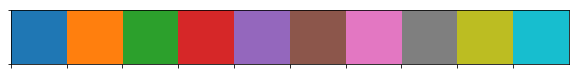

In [3]:
#  今のカラーパレットを確認
sns.palplot(color)

In [4]:
dfb = pd.DataFrame({'a' : ['one', 'one', 'two', 'three', 'two', 'one', 'six'], 'c' : np.arange(7)})

In [5]:
dfb['c'][dfb.a.str.startswith('o')] =42
# インデックスを操作しようとすると
#  pd.options.mode.chained_assignment = 'warn'にすると警告がでる（デフォルト）のでNoneにすると警告を出さない
# https://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-evaluation-order

コンペで使うファイルをリストアップしよう!

In [6]:
from subprocess import check_output # python上でunixコマンドを使うライブラリ
print(check_output(['ls', './competitions/instacart-market-basket-analysis']).decode('utf-8')) # lsして文字列をutf-8で返す

# 古い話？ jupyter上なら下記でも直で実行できる
# ls ./competitions/instacart-market-basket-analysis/

# あとで知ったのだがcsv.zip形式でも読み込めることがわかった

aisles.csv
aisles.csv.zip
departments.csv
departments.csv.zip
order_products__prior.csv
order_products__prior.csv.zip
order_products__train.csv
order_products__train.csv.zip
orders.csv
orders.csv.zip
products.csv
products.csv.zip
sample_submission.csv
sample_submission.csv.zip



探索的分析に潜る前に、ファイルについてちょっと知っておきましょう。すべてのファイルをデータフレームにしてちょっと見てみよう。

In [7]:
# read_csvでcsvファイルの中身を読み込むことができる
# zipでも読み込め nrowsで件数を指定できる
dir_str = './competitions/instacart-market-basket-analysis'
order_products_train_df = pd.read_csv(dir_str + "/order_products__train.csv")
order_products_prior_df = pd.read_csv(dir_str + "/order_products__prior.csv")
orders_df = pd.read_csv(dir_str + "/orders.csv")
products_df = pd.read_csv(dir_str + "/products.csv")
aisles_df = pd.read_csv(dir_str + "/aisles.csv")
departments_df = pd.read_csv(dir_str + "/departments.csv")

In [8]:
orders_df.head()
# 先頭５件のデータを表示
# すべての注文データが入っている。
# days_since_prior_orderに欠損値が。初注文の場合はNan?

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [11]:
# 前回注文履歴をみる
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
# トレーニングセットの注文情報をみる
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [9]:
orders_df.count() 
# 各項目の件数を数える、days_since_prior_orderのみ欠損値がある模様。

order_id                  3421083
user_id                   3421083
eval_set                  3421083
order_number              3421083
order_dow                 3421083
order_hour_of_day         3421083
days_since_prior_order    3214874
dtype: int64

見たところ、order.csvはすべての情報がありそう（買った人、いつ買ったか、前回注文から何日たっているかなど）

order_products_trainとorder_products_prior は同じ項目がある。
　何が違うんでしょうか？

先程述べたように、このデータセットでは、顧客の4-100の注文が与えられます。（あとでわかりますよ）
我々は再注文される製品を予測する必要がある。
ユーザの最後の注文が取り出されて、トレーニングセットと（モデル確認の）テストセットに分かれている。
order_products_priorファイルは顧客のすべての事前注文情報が含まれています。
また、eval_setと呼ばれるorders.csvファイルにはトレーニング用、テスト用、前回注文セットのどれなのか
を示す項目がある。
order_products****.csvには指定された順序で購入製品に関する詳しい情報と並び順が記載されています。

まず３つのデータセットの列を数えてみましょう。

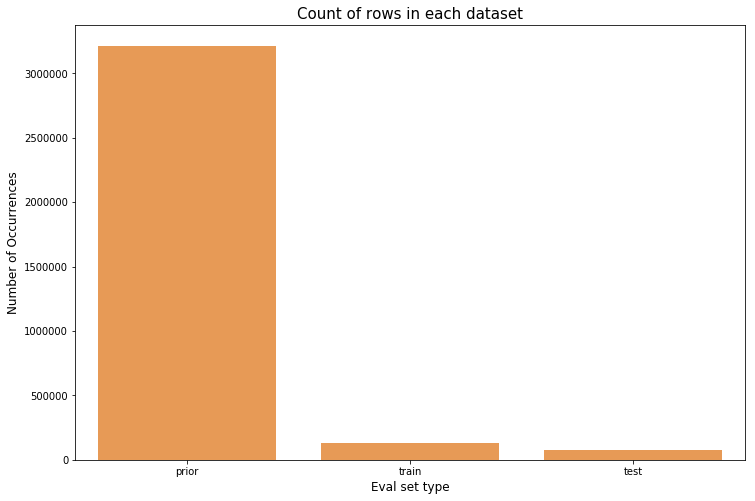

In [14]:
cnt_srs = orders_df['eval_set'].value_counts()
# その項目で出てくる値がいくつあるか集計する
# 今回はprior, train, testの３つ
plt.figure(figsize=(12 ,8))
# 棒グラフで表示
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
# plt.xticks(rotation='vertical') 垂直にするが見づらいのでデフォルトにする
plt.xticks()
plt.show()
# 圧倒的にpriorが多い

In [33]:
# データの重複を省く
def get_unique_count(x):
    return len(np.unique(x))

# " eval_set"順に並び替えて、['user_id']項目のリストから重複を覗く
# aggregateはもうちょっと詳細確認する
# aggでも同じことができるよ！
cnt_srs = orders_df.groupby("eval_set")['user_id'].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

In [36]:
# orders_df.groupby("eval_set").head()
# prior, test, trainごとにユーザはどれくらいいるか？
orders_df.groupby("eval_set")["user_id"].agg(get_unique_count)

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

206209人顧客がいて、トレーニングセットが131209人分で予測して当てるテストが75000人分ある。

さて顧客ごとに4-100の注文があることを検証してみましょう。

In [41]:
# user_idでソートしてorder_numberの項目を出して、idごとにorder_numberが最も大きいものを集計する
#  そのごインデックスを振り直す。
# それぞれのオーダーの最大をみる（その注文で何個注文したか）
cnt_srs = orders_df.groupby("user_id")['order_number'].aggregate(np.max).reset_index()
# インデックスを振り直すことでuser_id,order_numberがカラムとなるDataFrameとなるため何かと扱いやすくなる。
cnt_srs = cnt_srs['order_number'].value_counts() # 数を数える、大きい順に並び替えるようなのでbarplotしたときにそのままで分かりやすい。
# cnt_srs.['order_number']はcnt_srs.order_numberとも書けるが項目名なのか変数なのかわかりづらくなるのでおすすめはしない。

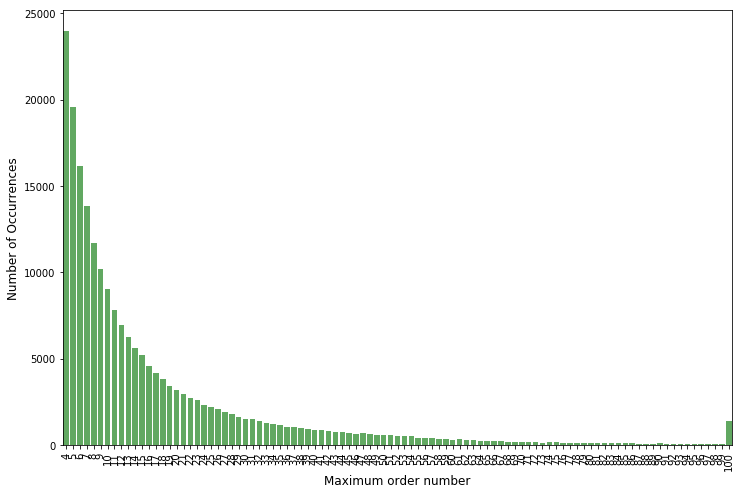

In [40]:
# barplotで棒グラフを表示する
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color = color[2])
plt.ylabel('Number of Occurrences', fontsize =12) # y軸のラベル名とフォントサイズを設定
plt.xlabel('Maximum order number', fontsize = 12) # x軸のラベル名とフォントサイズを設定
plt.xticks(rotation='vertical') # 文字がかぶって見づらいためx軸のラベル名を垂直方向に回転
plt.show() # 表示 %matplotlib inlineがあるためjupyter notebook上では必要ない

ちゃんと４−１００に収まっていることがわかる。
次に曜日によって何か癖があるか見てみよう！

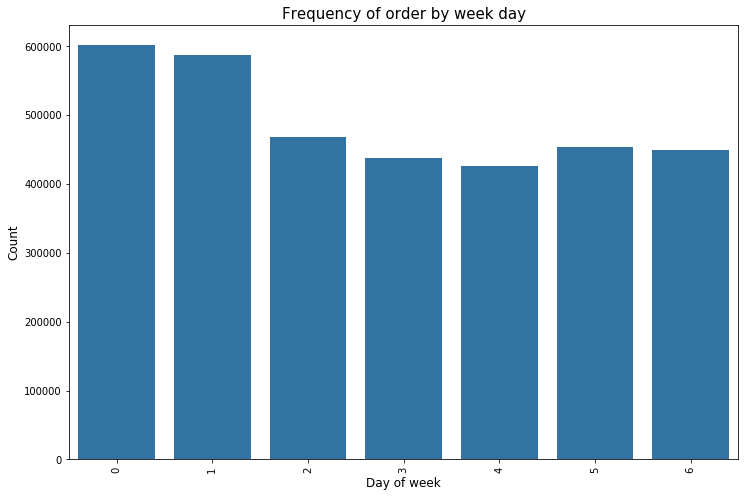

In [42]:
# order_dowごとに件数をカウントして表示
plt.figure(figsize=(12,8))
sns.countplot(x='order_dow', data=orders_df, color=color[0]) # カラーパレット
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

０，１が土日で高めで水曜日にかけて下がっていく

次に１日の時間ごとの観点で分布を見てみよう

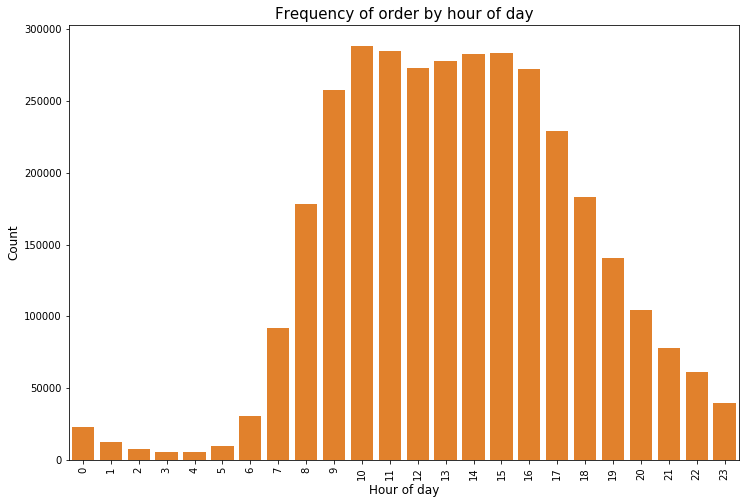

In [43]:
# 時間帯ごとに件数をカウント
plt.figure(figsize=(12,8))
sns.countplot(x='order_hour_of_day', data=orders_df, color=color[1])
plt.ylabel("Count", fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

主に日中に注文されてるね。
じゃあ、曜日と時間を組み合わせて見てみよう

In [20]:
# 曜日と時間帯ごとに注文数を集計してインデックスを振り直す
grouped_df = orders_df.groupby(['order_dow', 'order_hour_of_day'])['order_number'].aggregate('count').reset_index()
grouped_df.head() # できているか確認する

,order_dow,order_hour_of_day,order_number
0,0,0,3936
1,0,1,2398
2,0,2,1409
3,0,3,963
4,0,4,813


In [17]:
grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')
# ピポッドの挙動確認

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,
0,3936,2398,1409,963,813,1168,3329,12410,28108,40798,...,54552,53954,49463,39753,29572,22654,18277,14423,11246,6887
1,3674,1830,1105,748,809,1607,5370,16571,34116,51908,...,46764,46403,44761,36792,28977,22145,16281,11943,8992,5620
2,3059,1572,943,719,744,1399,4758,13245,24635,36314,...,37173,37469,37541,32151,26470,20084,15039,10653,8146,5358
3,2952,1495,953,654,719,1355,4562,12396,22553,32312,...,34773,35990,35273,30368,25001,19249,13795,10278,8242,5181
4,2642,1512,899,686,730,1330,4401,12493,21814,31409,...,33625,34222,34093,29378,24425,19350,14186,10796,8812,5645
5,3189,1672,1016,841,910,1574,4866,13434,24015,34232,...,37407,37508,35860,29955,24310,18741,13322,9515,7498,5265
6,3306,1919,1214,863,802,1136,3243,11319,22960,30839,...,38748,38093,35562,30398,24157,18346,13392,10501,8532,6087


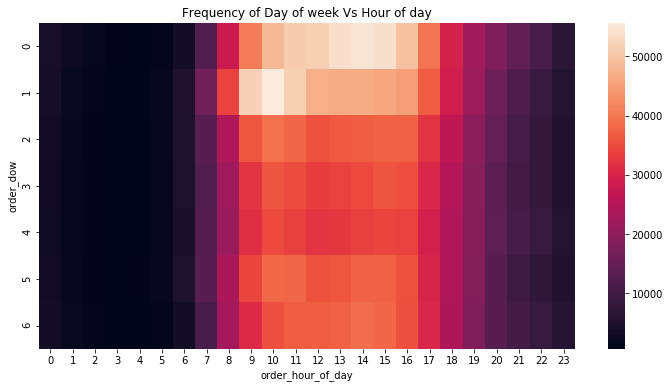

In [21]:
# order_dow,order_hour_of_dayを軸としてピポッドする
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df) # 各セルごとに数値によって色分けしてプロットしてくれる
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()
# 頻度が多い場所ほど明るく表示されている

土曜の夕方と日曜の朝がかきいれ時みたい。

次に注文間隔を調べてみよう。

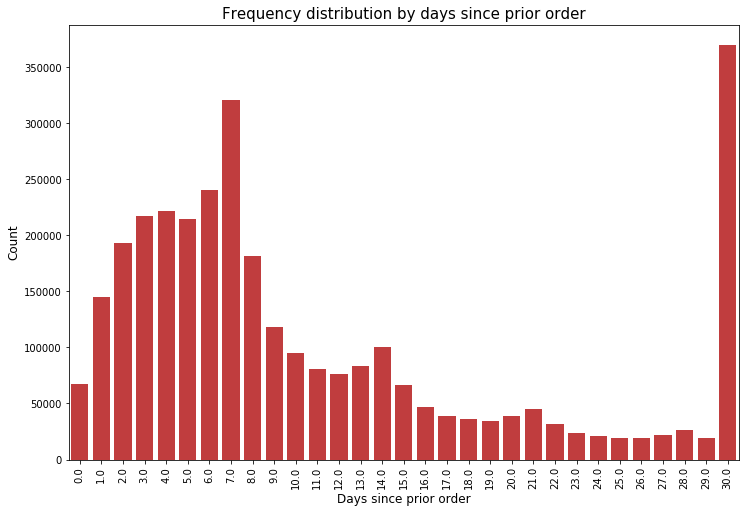

In [47]:
# 日付ごとに注文数を確認する
plt.figure(figsize=(12,8))
sns.countplot(x='days_since_prior_order', data=orders_df, color=color[3])
# x軸で出てくるカテゴリーごとに頻度を数えてプロットする
# 1 2 2 3 2 0 3なら
# 0 1
# 1 1
# 3 2
# 2 3 となる
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

週１か月１で注文してそうだね。小さなピークだと１４日、２１日と２８日おき（２，３，４週おき）があるね。

僕らの目的は再注文がわかることだから、以前のセットとトレーニングセットの再注文率をチェックしましょう

In [48]:
# priorセットの再注文率
order_products_prior_df.reordered.sum()/order_products_prior_df.shape[0]

0.5896974667922161

In [49]:
# トレーニングセットの再注文率
order_products_train_df.reordered.sum()/order_products_train_df.shape[0]

0.5985944127509629

平均して、５９％の商品がリピートされていますね。

### リピートのない商品：

さて５９％の商品がリピートされているのがわかって、全くリピートされないものもあるとわかった。
それを見てみよう。

In [23]:
# 再注文数をorder_idごとに集計
order_products_prior_df.groupby('order_id')['reordered'].agg("sum")

order_id
2           6
3           8
4          12
5          21
6           0
7           0
8           1
9          10
10          8
11          5
12          6
13          0
14          9
15          5
16          1
18         10
19          3
20          0
21          3
22         10
23          9
24          0
25          8
26          2
27         16
28         14
29          5
30          2
31          9
32          5
           ..
3421048     5
3421050     4
3421051    26
3421052     2
3421053     9
3421055    10
3421057     4
3421059     1
3421060     6
3421061    20
3421062     4
3421064     3
3421065     4
3421066     2
3421067     1
3421068     1
3421069    11
3421071     1
3421072     3
3421073     0
3421074     1
3421075     8
3421076     7
3421077     0
3421078     7
3421079     0
3421080     4
3421081     0
3421082     4
3421083     4
Name: reordered, Length: 3214874, dtype: int64

In [24]:
# warningの内容を確認する
# order_idで並び替えて「再注文」の項目を出し、その数の合計を集計してインデックスを振り直す
grouped_df = order_products_prior_df.groupby('order_id')['reordered'].agg("sum").reset_index()
grouped_df['reordered'].ix[grouped_df['reordered']>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]
# ix は廃止になったよ
# locかiloc
# ラベルで探すなら locでインデックス指定ならilocを使ってね

/Users/kzfm/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [26]:
# 注文ごとに再注文された数を集計する
grouped_df = order_products_prior_df.groupby('order_id')['reordered'].agg("sum").reset_index()
# 再注文が１件でもあったものを1にする
grouped_df['reordered'].loc[grouped_df['reordered']>1] = 1
# 再注文率を確認
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [30]:
# トレーニングデータセットも同じように確認する
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

priorセットの約１２％は注文がなく、トレーニングセットでは６．５％だ。

次にそれぞれの注文で購入された製品の種類数を見ていこう。

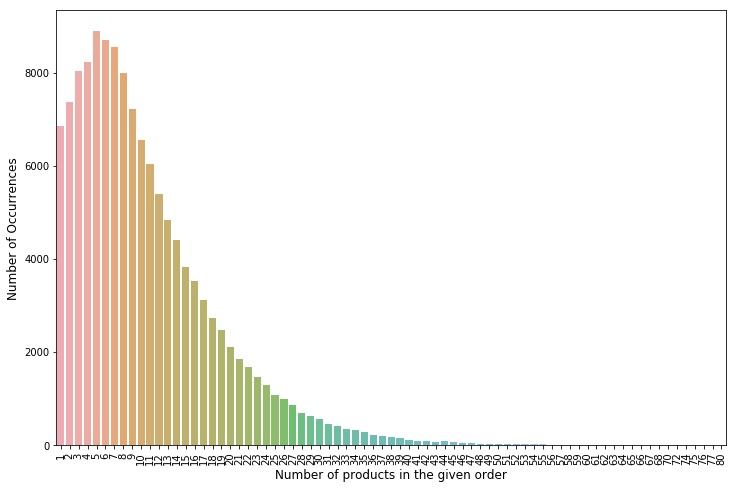

In [32]:
# トレーニングセットで注文ごとに
grouped_df = order_products_train_df.groupby('order_id')['add_to_cart_order'].aggregate('max').reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

最大が５の右肩下がりの分布だね
製品を詳しく調べる前に他の３ファイルも調べておこう

In [33]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [34]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [36]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


この３つの製品の詳細をorder_priorにマージしてみよう

In [37]:
# データを結合する
# onをキーとして　結合する。 howオプションは以下の通り　
# inner: 既定。内部結合。両方のデータに含まれるキーだけを残す。
# left: 左外部結合。ひとつめのデータのキーをすべて残す。
# right: 右外部結合。ふたつめのデータのキーをすべて残す。
# outer: 完全外部結合。すべてのキーを残す。

order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [38]:
# 製品名ごとにカウントして、その結果に項目名、'product_name', 'frequency_count' とつける。
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


なんと！オーガニック製品ばっかりでしかもほとんどフルーツだな！

重要なaisle(種別？)を見てみよう！

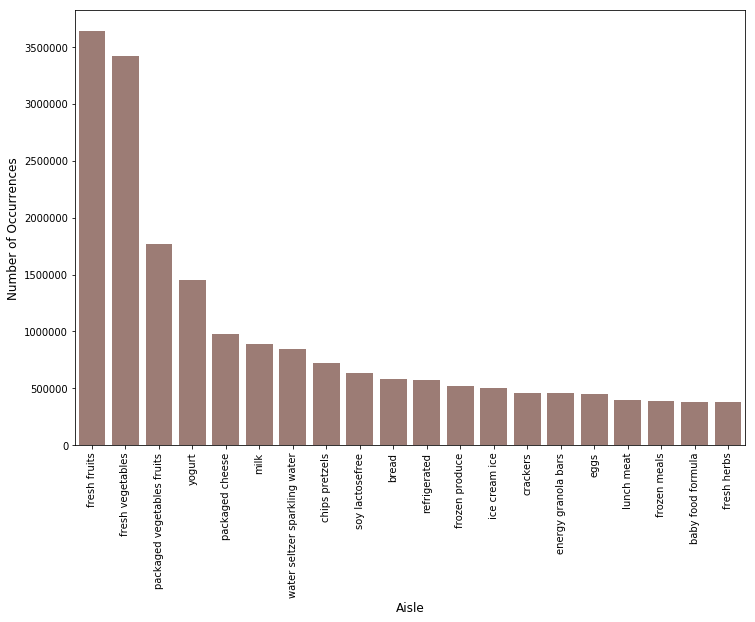

In [39]:
# isle(種別？)ごとに数え、上位２０までをcnt_srsに格納
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
# バープロットで表示 alphaはグラフの透過度デフォルトは1(透過しない)で0に近づくほど薄くなる
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

トップ２の売り場？は新鮮フルーツと新鮮野菜だ！

部門別の分布：

部門別の分布を確認しましょう。

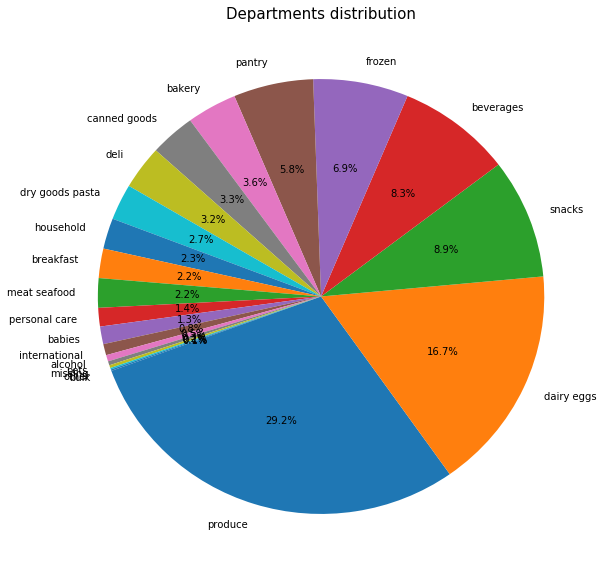

In [40]:
#　部門別に数えるてその割合を計算する 
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series/ temp_series.sum())*100))
# 円グラフをプロットする
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

作物は最大の部門になります。
さてそれぞれの部署の再注文率を見てみましょう。

### 部門別再注文率

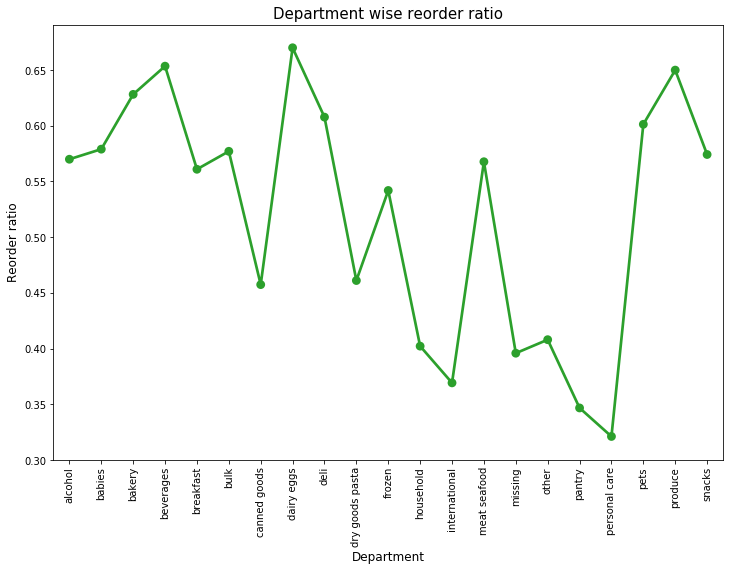

In [41]:
# 部門ごとの再注文率を集計しプロットする。
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

パーソナルケアは一番再注文率が低くて、乳製品や卵は一番高いね

### 売り場の再注文率：

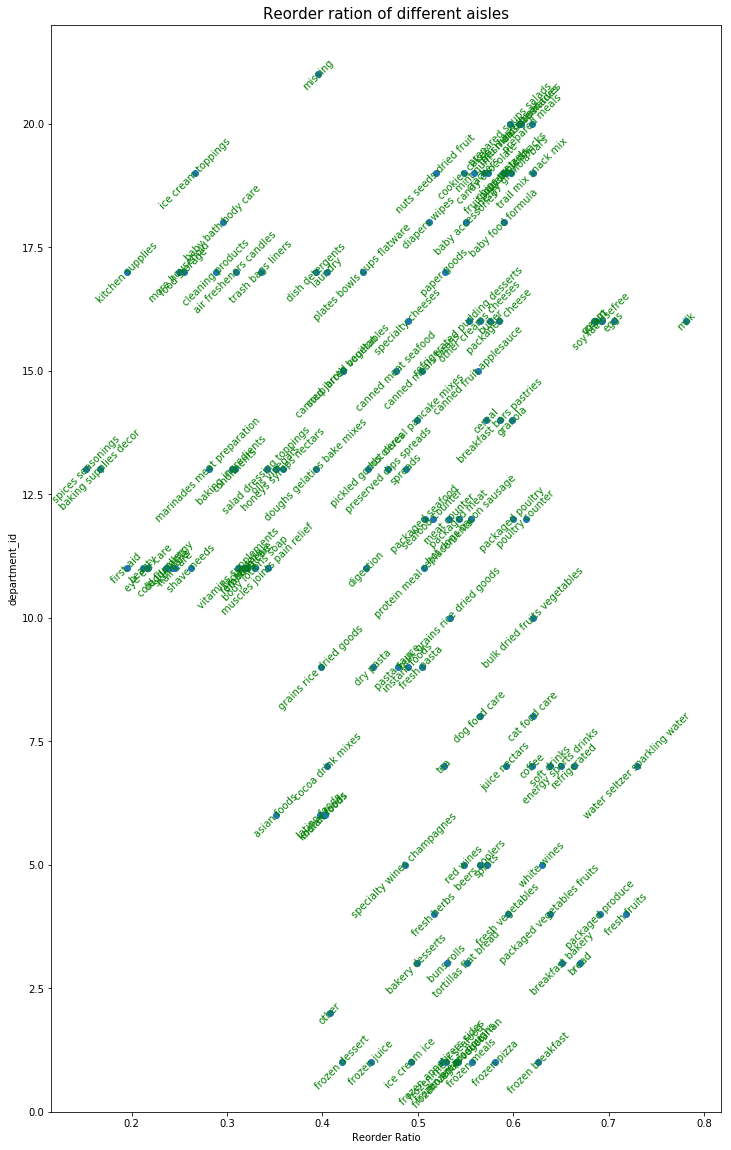

In [43]:
# 部門IDとaisle(種別?)別に再注文率を集計
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
# 点ごとにテキストを表示する 下記が分かりやすい
# https://qiita.com/kujirahand/items/bdc574102148c7f1f041
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]),rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ration of different aisles", fontsize=15)
plt.show()

※正直見やすいかと言われると微妙なところ

### カートに加えることと再注文率

注文した順番が再注文率に関係するか見てみよう！
（なんとなく真っ先に注文したものは毎回選ぶような気がするよね！）

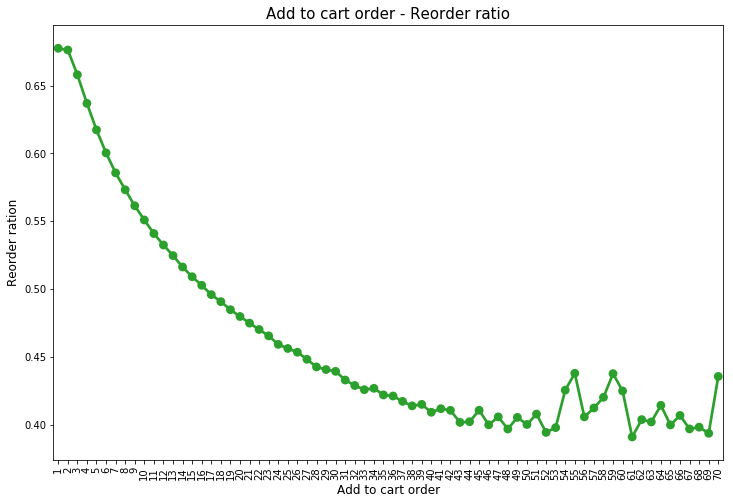

In [49]:
# カートに入れる順番を別の項目として作成
order_products_prior_df['add_to_cart_order_mod'] = order_products_prior_df['add_to_cart_order'].copy()
# 70以上はすべて70にする
order_products_prior_df['add_to_cart_order_mod'].loc[order_products_prior_df['add_to_cart_order_mod']>70]=70
# カートに入れる順番ごとに再注文率を集計
grouped_df = order_products_prior_df.groupby(['add_to_cart_order_mod'])['reordered'].agg("mean").reset_index()

# プロットする
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values,grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ration', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title('Add to cart order - Reorder ratio', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

最初にカートに加えたものあとに入れたものより再注文されているね！
これはよく買うものをまずカートにいれてから新しいものを探すからだね。

### 時間軸でみた再注文率

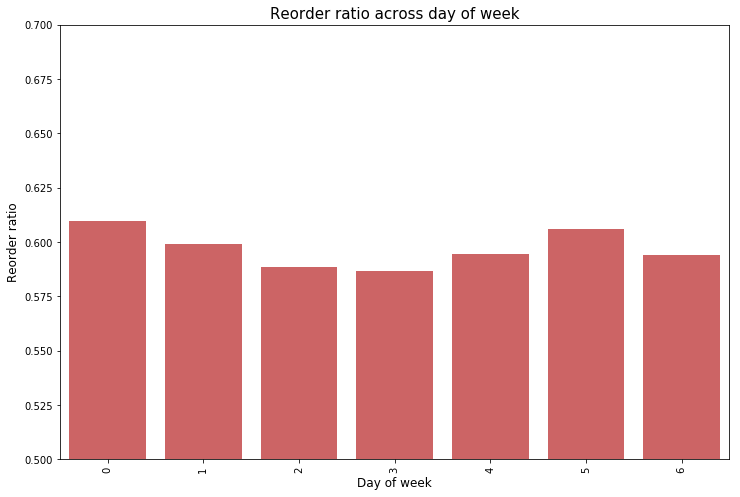

In [50]:
# オーダーIDをもとにorder_products_train_dfにorders_dfを左結合
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
# 曜日ごとの再注文率を集計
grouped_df = order_products_train_df.groupby(['order_dow'])['reordered'].agg('mean').reset_index()

# 棒グラフで表示する
plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

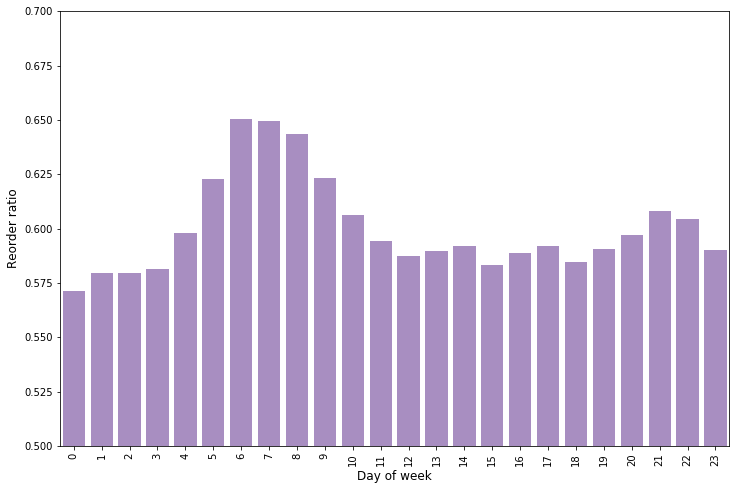

In [51]:
# 時間帯ごとに再注文率を集計しプロットする
grouped_df = order_products_train_df.groupby(['order_hour_of_day'])['reordered'].agg('mean').reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color= color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()
# 朝方が再注文率が高いね

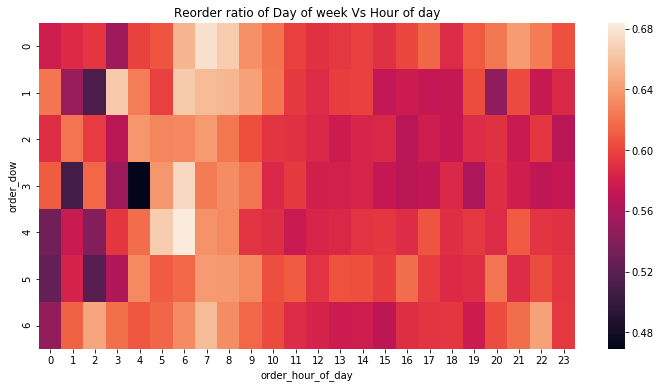

In [53]:
# 曜日、時間帯ごとに再注文率を集計
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
# ヒートマップにするためにピポッドする
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

# 曜日、時間帯ごとの再注文率をヒートマップで表示
plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

再注文率は早めの朝が他の時間帯よりかなり高いです

### 助けてくれれば幸いです。コメントや提案などを残してください。